In [2]:
!pip install -q ../introdl/

In [2]:
# imports and configuration

# uncomment to use a custom environment file
# from dotenv import load_dotenv
# load_dotenv('../main.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import OneCycleLR

import torchvision.transforms.v2 as T

from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

from introdl.utils import get_device, load_results, summarizer, load_model
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, image_to_PIL, plot_transformed_images, create_image_grid

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


In [61]:
mean = [0.485, 0.456, 0.406]  # Example mean values, replace with yours if needed
std = [0.229, 0.224, 0.225]  # Example std values, replace with yours if needed

transform_train = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize(224, max_size=None),  # Resize so the shortest edge is 256
    T.CenterCrop(224),            # Center crop to 256x256
    T.RandomRotation(degrees=15),
    T.RandomCrop(224, padding=10),            # Random crop to 224x224
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomGrayscale(),
    T.Normalize(mean=mean, std=std),
    T.ToPureTensor()
])

transform_val = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize(224, max_size=None),  # Resize so the shortest edge is 256
    T.CenterCrop(224),            # Center crop to 256x256
    T.Normalize(mean=mean, std=std),
    T.ToPureTensor()
])



In [62]:
full_train_dataset = ImageFolder(DATA_PATH / 'cats_dogs_foxes',transform=transform_train)
full_val_dataset = ImageFolder(DATA_PATH / 'cats_dogs_foxes', transform=transform_val)
train_indices, val_indices = train_test_split(list(range(len(full_train_dataset))), train_size=0.8, random_state=42)

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_val_dataset, val_indices)

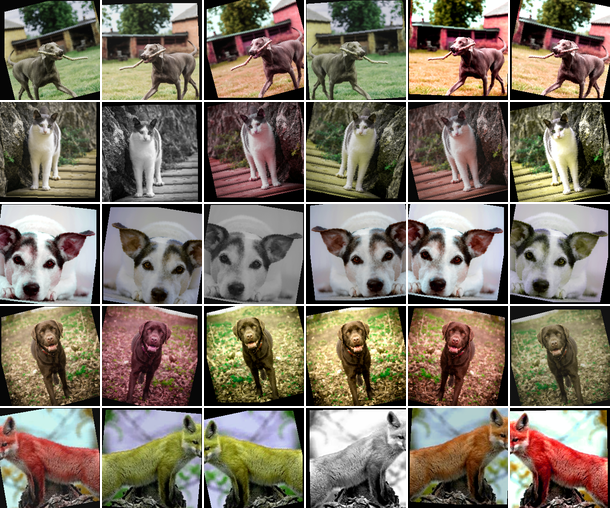

In [57]:
plot_transformed_images(train_dataset, img_size=(100,100), mean=mean, std=std)

In [63]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## Downloading and Preparing a Model for a New Task

In [64]:
class MobileNetV3SmallCustom(nn.Module):
    """
    A custom MobileNetV3 Small model for transfer learning.
    This class modifies the final fully connected layer of a pre-trained MobileNetV3 Small model
    to match the number of output classes specified.
    Attributes:
        model (torchvision.models.MobileNetV3): The MobileNetV3 Small model with a modified fully connected layer.
    Methods:
        forward(x):
            Defines the forward pass of the model.
        freeze_backbone():
            Freezes all layers except the final fully connected layer.
        unfreeze_backbone():
            Unfreezes all layers in the model.
    Args:
        num_outputs (int): The number of output classes for the final fully connected layer.
        weights (Optional[torchvision.models.MobileNet_V3_Small_Weights], optional): Pre-trained weights to load into the model. Defaults to None.
    """
    def __init__(self, num_outputs, weights=None):
        super(MobileNetV3SmallCustom, self).__init__()
        self.model = mobilenet_v3_small(weights=weights)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, num_outputs)

    def forward(self, x):
        return self.model(x)
    
    def freeze_backbone(self):
        """
        Freezes all layers except the final fully connected layer.
        """
        for param in self.model.features.parameters():
            param.requires_grad = False
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        """
        Unfreezes all layers in the model.
        """
        for param in self.model.parameters():
            param.requires_grad = True

## Training from Scratch

The dataset has only 308 images before splitting into training and validation sets so training any sort of CNN from scratch is going to be hopeless.  Let's try it anyway.  We've selected the MobileNetV3_Small model because it is relatively small at about 2.5 million parameters and is designed for efficiency on edge devices like phones.  

Here we'll load the model without any pretrained model weights and train it for 10 epochs using our usual workflow.

In [7]:
model = MobileNetV3SmallCustom(num_outputs=3)
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_from_scratch_mnv3.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file)

cuda


Epoch:   0%|          | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

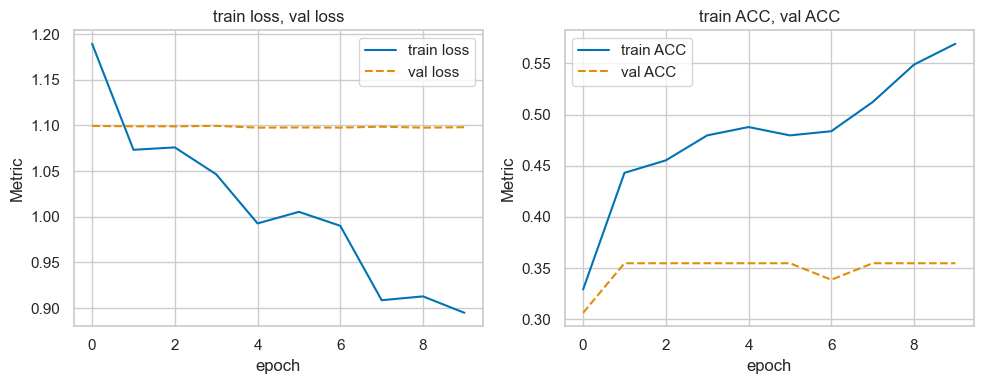

In [9]:
ckpt_file = MODELS_PATH / 'L05_from_scratch_mnv3.pt'
AdamW_augment = load_results(ckpt_file)

plot_training_metrics(AdamW_augment, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

Notice that the model accuracy is about 35% on the validation set which is little better than guessing since there are only three classes in this data.  The model is memorizing the training data and completely failing to generalize to the validation data.  Training from scratch simply isn't going to work here.

## Transfer Learning

In [10]:
# Load the pre-trained model
model = MobileNetV3SmallCustom(num_outputs=3, weights='DEFAULT')

# Freeze the backbone of the model
model.freeze_backbone()

# Configure Training
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer
device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_frozen_backbone_mnv3.pt'
epochs = 2

score_funcs = {'ACC':accuracy_score}

# Train and save
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file)

cuda


Epoch: 100%|██████████| 2/2 [00:59<00:00, 29.66s/it, train_loss=0.327, val_loss=0.336]


In [11]:
results

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,19.468869,0.783863,0.321325,0.650407,0.854839
1,1,39.207326,0.326985,0.336129,0.910569,0.887097


In [12]:
# load the model with the frozen backbone and unfreeze it
model = load_model(MobileNetV3SmallCustom(num_outputs=3), MODELS_PATH / 'L05_frozen_backbone_mnv3.pt')
model.unfreeze_backbone()

# Configure Training for unfrozen model
ckpt_file = MODELS_PATH / 'L05_unfrozen_backbone_mnv3.pt'
epochs = 3
optimizer = optim.AdamW(model.parameters())
scheduler = OneCycleLR(optimizer, max_lr=0.001, epochs=epochs, steps_per_epoch=len(train_loader))
#scheduler = None

# Train and save
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        lr_schedule=scheduler,
                        scheduler_step_per_batch=True,
                        early_stop_crit='max',
                        early_stop_metric='ACC',
                        patience=1)

Epoch:  67%|██████▋   | 2/3 [01:36<00:48, 48.11s/it, train_loss=0.0235, val_loss=0.45] 

Early stopping at epoch 2


In [13]:
ckpt_file = MODELS_PATH / 'L05_unfrozen_backbone_mnv3.pt'
results = load_results(ckpt_file)
results

,epoch,total time,train loss,val loss,train ACC,val ACC,lr
0,0,21.424694,0.213703,0.256503,0.947154,0.870968,0.000972
1,1,41.922761,0.073057,0.376023,0.983740,0.870968,0.000371


Notice that the best validation accuracy we achieved was with the frozen backbone.  Unfreezing and further training make the validation accuracy decrease.  This can happen with very small datasets or for datasets that are dissimilar to the original training data (usually Imagenet).  We'll reload the frozen backbone model and evaluate its overall performance.

In [ ]:
def classifier_predict(dataset, model, device, batch_size=32, return_labels=False):
    """
    Collects predictions from a PyTorch dataset using a classification model.
    Optionally returns ground truth labels.

    Assumptions:
        - The model outputs logits for each class (not probabilities or class indices).
        - The dataset returns tuples of (inputs, labels) where labels are integers representing class indices.

    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to evaluate.
        model (torch.nn.Module): The classification model. Assumes outputs are logits for each class.
        device (torch.device): The device to run the evaluation on.
        return_labels (bool): Whether to return ground truth labels along with predictions.
        batch_size (int): The batch size for the DataLoader.

    Returns:
        list: Predicted labels (class indices).
        list (optional): Ground truth labels (if return_labels=True).
    """
    # Create a DataLoader for the dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Set the model to evaluation mode
    model.eval()
    model.to(device)
    
    # Initialize lists to store predictions and ground truth labels
    predictions = []
    ground_truth = [] if return_labels else None

    # Turn off gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move inputs and labels to the specified device
            inputs = inputs.to(device)
            if return_labels:
                labels = labels.to(device)

            # Forward pass through the model
            logits = model(inputs)

            # Get predicted labels (the class with the highest logit)
            preds = torch.argmax(logits, dim=1)

            # Append predictions to the list
            predictions.extend(preds.cpu().tolist())
            # Append ground truth labels if requested
            if return_labels:
                ground_truth.extend(labels.cpu().tolist())

    if return_labels:
        return predictions, ground_truth
    return predictions


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


def evaluate_classifier(model, dataset, device, display_confusion=True, img_size=(5, 5), batch_size=32):
    """
    Evaluates the model on the given dataset, plots the confusion matrix if specified,
    and returns the confusion matrix, classification report, and misclassified dataset.

    Parameters:
        model (torch.nn.Module): The model to evaluate.
        dataset (torch.utils.data.Dataset): The dataset to evaluate on.
        device (torch.device): The device to run the evaluation on.
        display_confusion (bool): Whether to display the confusion matrix. Defaults to True.
        img_size (tuple): The size of the confusion matrix plot. Defaults to (5, 5).

    Returns:
        tuple: (confusion matrix, classification report, misclassified dataset)
    """
    # Get predictions and labels using the classifier_predict function
    pred_labels, labels = classifier_predict(dataset, model, device, return_labels=True, batch_size=batch_size)

    # Collect misclassified indices
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(labels, pred_labels)) if true != pred]

    print(f'The dataset has {len(dataset)} samples.')
    print(f'The model misclassified {len(misclassified_indices)} samples.')

    # Check to see if classes are available in dataset.classes or dataset.dataset.classes
    if hasattr(dataset, 'classes'):
        classes = dataset.classes
    elif hasattr(dataset.dataset, 'classes'):
        classes = dataset.dataset.classes
    else:
        classes = None

    # Create a list of strings in the form "truth / predict" for each misclassified index
    misclassified_labels = []
    for idx in misclassified_indices:
        true_label = classes[labels[idx]] if classes else labels[idx]
        pred_label = classes[pred_labels[idx]] if classes else pred_labels[idx]
        misclassified_labels.append(f'{true_label} / {pred_label}')

    # Create a new dataset containing only the misclassified images
    class MisclassifiedDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, misclassified_indices, misclassified_labels):
            self.dataset = dataset
            self.misclassified_indices = misclassified_indices
            self.misclassified_labels = misclassified_labels

        def __len__(self):
            return len(self.misclassified_indices)

        def __getitem__(self, idx):
            original_idx = self.misclassified_indices[idx]
            image, _ = self.dataset[original_idx]
            label = self.misclassified_labels[idx]
            return image, label

    misclassified_dataset = MisclassifiedDataset(dataset, misclassified_indices, misclassified_labels)

    # Compute the confusion matrix
    confusion_mat = confusion_matrix(labels, pred_labels)

    # Display the confusion matrix if specified
    if display_confusion:
        fig, ax = plt.subplots(figsize=img_size)
        disp = ConfusionMatrixDisplay(confusion_mat, display_labels=classes if classes else None)
        disp.plot(ax=ax)
        plt.show()

    # Generate the classification report
    class_report = classification_report(labels, pred_labels, target_names=classes if classes else None)

    return confusion_mat, class_report, misclassified_dataset

The dataset has 62 samples.
The model misclassified 7 samples.


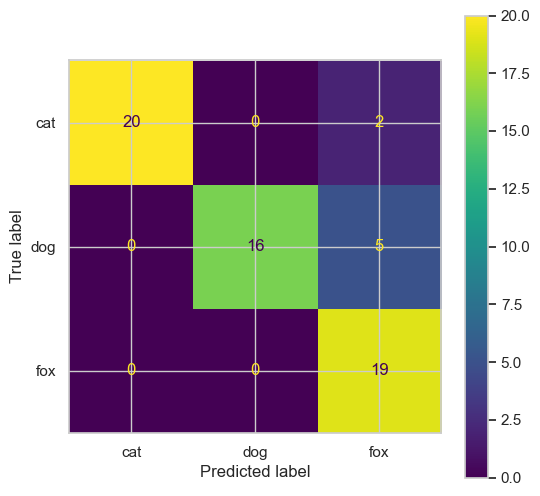

In [39]:
model = load_model(MobileNetV3SmallCustom(num_outputs=3), MODELS_PATH / 'L05_frozen_backbone_mnv3.pt')
device = get_device()
conf_mat,report,misses_dataset=evaluate_classifier(model, val_dataset, device)


In [40]:
# show the classification report
print(report)

              precision    recall  f1-score   support

         cat       1.00      0.91      0.95        22
         dog       1.00      0.76      0.86        21
         fox       0.73      1.00      0.84        19

    accuracy                           0.89        62
   macro avg       0.91      0.89      0.89        62
weighted avg       0.92      0.89      0.89        62



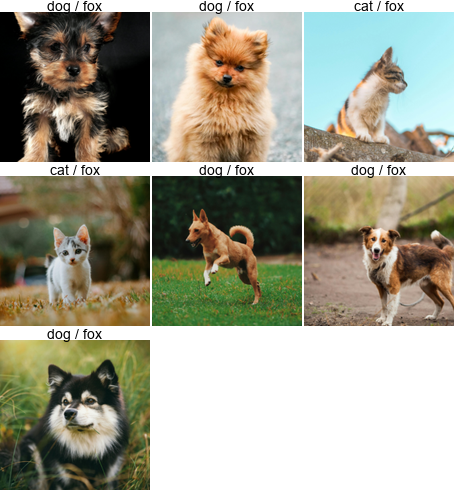

In [41]:
create_image_grid(misses_dataset, nrows=3, ncols=3, img_size=(150, 150), show_labels=True, mean=mean, std=std)

## Transfer Learning - Larger Model

In [65]:
class ResNet50Custom(nn.Module):
    """
    A custom ResNet50 model for transfer learning.
    This class modifies the final fully connected layer of a pre-trained ResNet50 model
    to match the number of output classes specified.
    Attributes:
        model (torchvision.models.ResNet): The ResNet50 model with a modified fully connected layer.
    Methods:
        forward(x):
            Defines the forward pass of the model.
        freeze_backbone():
            Freezes all layers except the final fully connected layer.
        unfreeze_backbone():
            Unfreezes all layers in the model.
    Args:
        num_outputs (int): The number of output classes for the final fully connected layer.
        weights (Optional[torchvision.models.ResNet50_Weights], optional): Pre-trained weights to load into the model. Defaults to None.
    """
    def __init__(self, num_outputs, weights=None):
        super(ResNet50Custom, self).__init__()
        self.model = models.resnet50(weights=weights)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_outputs)

    def forward(self, x):
        return self.model(x)
    
    def freeze_backbone(self):
        """
        Freezes all layers except the final fully connected layer.
        """
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        """
        Unfreezes all layers in the model.
        """
        for param in self.model.parameters():
            param.requires_grad = True

In [66]:
model = ResNet50Custom(num_outputs=3, weights = "DEFAULT")
model.freeze_backbone()

loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_frozen_backbone_resnet50.pt'
epochs = 5

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_crit='max',
                        early_stop_metric='ACC',
                        patience=2)

cuda


Epoch: 100%|██████████| 5/5 [02:30<00:00, 30.04s/it, train_loss=0.243, val_loss=0.271]


In [67]:
results

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,19.788510,0.930077,0.752138,0.650407,0.919355
1,1,39.052650,0.619708,0.535041,0.951220,0.919355
2,2,60.309896,0.424931,0.385929,0.963415,0.951613
3,3,79.496857,0.327687,0.308429,0.967480,0.967742
4,4,99.679458,0.242739,0.270692,0.983740,0.935484


The dataset has 62 samples.
The model misclassified 2 samples.


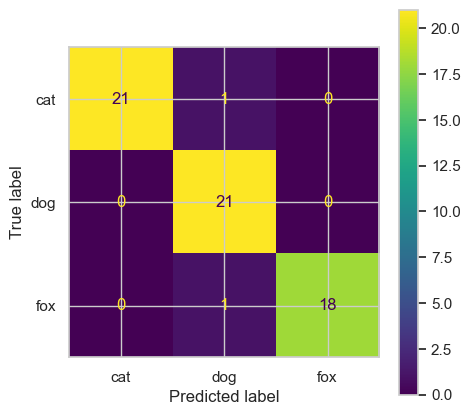

In [70]:
model = load_model(ResNet50Custom(num_outputs=3), MODELS_PATH / 'L05_frozen_backbone_resnet50.pt')
device = get_device()
conf_mat,report,missed_dataset=evaluate_classifier(model, val_dataset, device, confusion_size=(5,5))

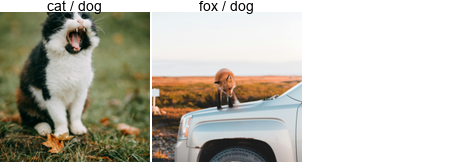

In [69]:
create_image_grid(missed_dataset, nrows=1, ncols=3, img_size=(150, 150), show_labels=True, mean=mean, std=std)